<a href="https://colab.research.google.com/github/Ioana-MI/sup-cif/blob/main/CIFAR10_VGG16_firstrun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Num GPUs Available:  1
GPU memory growth set
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 275s 408ms/step - accuracy: 0.2850 - loss: 2.0689 - val_accuracy: 0.5843 - val_loss: 1.2989
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 306s 409ms/step - accuracy: 0.4159 - loss: 1.5521 - val_accuracy: 0.6113 - val_loss: 1.2021
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 222s 345ms/step - accuracy: 0.4458 - loss: 1.4564 - val_accuracy: 0.6213 - val_loss: 1.1753
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 302s 409ms/step - accuracy: 0.4663 - loss: 1.4206 - val_accuracy: 0.6403 - val_loss: 1.0649
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 216s 345ms/step - accuracy: 0.4682 - loss: 1.3956 - val_accuracy: 0.6340 - val_loss: 1.0772
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 408ms/step - accuracy: 0.4838 - loss: 1.3502 - val_accuracy: 0.6504 - val_loss: 1.0619
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 409ms/step - accuracy: 0.4946 - loss: 1.3378 - val_accuracy: 0.6578

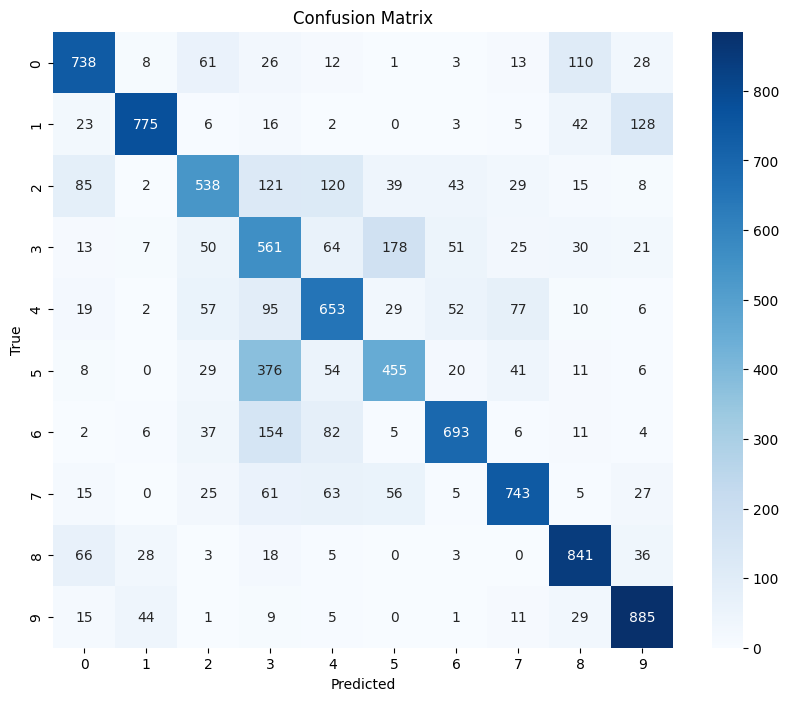

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.74      1000
           1       0.89      0.78      0.83      1000
           2       0.67      0.54      0.60      1000
           3       0.39      0.56      0.46      1000
           4       0.62      0.65      0.63      1000
           5       0.60      0.46      0.52      1000
           6       0.79      0.69      0.74      1000
           7       0.78      0.74      0.76      1000
           8       0.76      0.84      0.80      1000
           9       0.77      0.89      0.82      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Flatten labels
y_train = y_train.flatten()
y_test = y_test.flatten()

# Split into 80% for training and 20% for validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2
)

# Define hyperparameters
batch_size = 64
classes_num = 10
epochs_num = 15
dense_units = 256
img_height = 224
img_width = 224

# One-hot encode labels
y_train = tf.one_hot(y_train.astype(np.int32), depth=classes_num)
y_val = tf.one_hot(y_val.astype(np.int32), depth=classes_num)
y_test = tf.one_hot(y_test.astype(np.int32), depth=classes_num)

# Normalize pixel values
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Create tf.data.Dataset for efficient loading and preprocessing
def preprocess_image(image, label):
    image = tf.image.resize(image, (img_height, img_width))
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess_image) \
    .shuffle(1000) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)) \
    .map(preprocess_image) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess_image) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)


# Load pretrained VGG16 base without top layers
vgg16_base = tf.keras.applications.VGG16(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
vgg16_base.trainable = False

# Build the model
model = tf.keras.models.Sequential([
    vgg16_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(classes_num, activation='softmax'),
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_num,
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predictions on test set (probabilities)
y_pred_probs = model.predict(test_ds)

# Predicted classes (integers)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()

# True classes (integers)
y_true = tf.argmax(y_test, axis=1).numpy()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(classes_num)],
            yticklabels=[str(i) for i in range(classes_num)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred))